# Problem statement.

Kaggle competition @
https://www.kaggle.com/center-for-policing-equity/data-science-for-good

How do you measure justice? And how do you solve the problem of racism in policing? We look for factors that drive racial disparities in policing by analyzing census and police department deployment data. The ultimate goal is to inform police agencies where they can make improvements by identifying deployment areas where racial disparities exist and are not explainable by crime rates and poverty levels.


### Exploring Data
Dataset consists of 19 departmentwise folder. Each department folder has.  
1. One subfolder containing shapefiles of police departments.  
2. Other subfolder has ACS socio-economic data.  
3. A file with police records for incidents/crimes.  

Quick scan of files and as also specified in the problem statement, data is not consistent/uniform accross folders. Also geospatial data(coordinates) does not seem to follow same standards even within a department data.  

Using geopandas, pandas, shapely and matplotlib libraries for geospatial and tabular data wrangling and basic matplotlib for plotting.

In [1]:
#Load libraries needed for the solution
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First folder choosen for solution is dept_24_00098 which is Ramsey County in MN.

## Dept_24-00098 - Ramsey County Minnesota.

ACS data has census track id in GEO.id and all associated census socio-economic data. However it does not have geospatial data for census tracks. Fortunately census.gov website has geospatial data for each of the states. Later it will be merged with ACS data.
Minnesota state census tracks shapefiles are downloaded from  
https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html  
The files are stord at ../Dept_24-00098/census_tracks

In [2]:
# read the census track data and inspect first few rows
base_path = '../input/cpe-data/'
census_tracks_mn = gpd.read_file(base_path+'Dept_24-00098/census_tracks/cb_2017_27_tract_500k.shp')
census_tracks_mn.head(2)

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,27,003,050208,1400000US27003050208,27003050208,502.08,CT,5687364,393200,"POLYGON ((-93.35732899999999 45.219614, -93.33..."
1,27,003,050232,1400000US27003050232,27003050232,502.32,CT,5504435,779522,"POLYGON ((-93.08155699999999 45.174834, -93.07..."


In [3]:
# Check the coordinate reference system. It is essential all geospatial data is in same CRS for doing any geospatial 
# data analysis.
census_tracks_mn.crs

{'init': 'epsg:4269'}

Read police presinct shapefiles and inspect first few rows

In [4]:
police_precinct_mn = gpd.read_file(base_path +
                                   'Dept_24-00098/24-00098_Shapefiles/StPaul_geo_export_6646246d-0f26-48c5-a924-f5a99bb51c47.shp')
police_precinct_mn.head(2)

,dist,gridnum,geometry
0,Western District,82,POLYGON ((-93.18731873325051 44.95984522374139...
1,Western District,62,"POLYGON ((-93.1891517284332 44.96150365239401,..."


In [5]:
police_precinct_mn.crs

{'init': 'epsg:4326'}

census track and police presinct are in different CRS. They need to be in same CRS.I am choosing a CRS with unot of measure in Meters. Rational further in the solution, there would be need for calculating area/distance, so these measures in meters/sq meters is sensible rather than degrees. Using EPSG:32118 CRS system.  

More details from https://epsg.io/32118  

Using geopandas to_crs function to convert to same CRS.

In [6]:
police_precinct_mn.to_crs({'init': 'epsg:32118', 'no_defs': True},inplace = True)
census_tracks_mn.to_crs({'init': 'epsg:32118', 'no_defs': True},inplace = True)

Overlaying police precinct data on MN state census tracks. This will give a perspective of data from which part and portion of state on MN is being analysed. It is tiny part!!

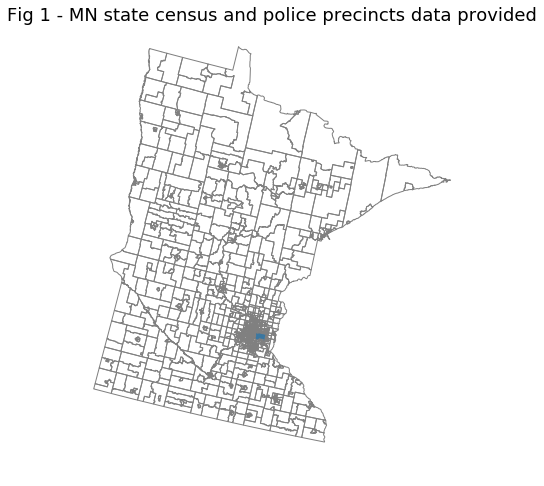

In [7]:
ax= census_tracks_mn.plot(facecolor = 'None', edgecolor = 'gray',figsize = (8,8))
ax.set_title('Fig 1 - MN state census and police precincts data provided', fontsize=18)
police_precinct_mn.plot(ax=ax)
ax.set_axis_off()

We need to extract susbset of census track data by ACS data provided. So picking education attainment file and read GEO.id. These will be used to extract.

In [8]:
# get the GEO.ids from ACS datafile for joining with census tracks.
acs_mn = pd.read_csv(base_path + 'Dept_24-00098/24-00098_ACS_data/24-00098_ACS_education-attainment/ACS_15_5YR_S1501_with_ann.csv',
                    skiprows = [1],
                    usecols=[0])
acs_mn.head(2)

,GEO.id
0,1400000US27123030100
1,1400000US27123030201


Using pandas merge function to merge census track data and ACS data.

In [9]:
census_acs_mn = pd.merge(census_tracks_mn, acs_mn, how = 'inner', left_on = 'AFFGEOID', right_on = 'GEO.id')

From Fig1.zoom in to ACS data overlayed with police precinct data.

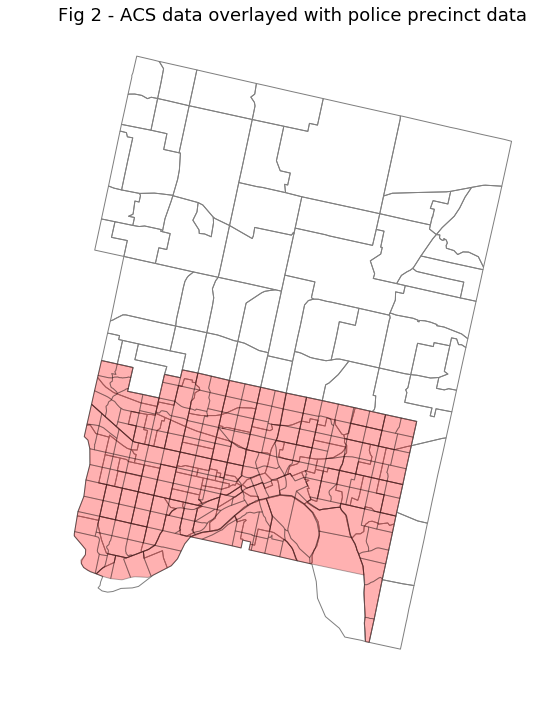

In [10]:
ax= census_acs_mn.plot(facecolor = 'None', edgecolor = 'gray',figsize = (12,12))
police_precinct_mn.plot(ax=ax, alpha = 0.3,edgecolor='black',facecolor='red')
ax.set_title('Fig 2 - ACS data overlayed with police precinct data', fontsize=18)
ax.set_axis_off()

Take away from above figure is  
1. police precinct dataset is subset of ACS data geospatially.  
2. There seems many to many relationship between police precinct and census track data.  
So it means ACS data need to sliced and diced by police presinct to compare/analyse data.

#### Read police records/incidents data.  
It has only vehicle stops data.

In [11]:
police_records_mn = pd.read_csv(base_path+'Dept_24-00098/24-00098_Vehicle-Stops-data.csv',
                            skiprows=[1])

In [12]:
police_records_mn.shape

(710472, 12)

In [13]:
police_records_mn.head()

,INCIDENT_DATE_YEAR,INCIDENT_DATE,SUBJECT_RACE,SUBJECT_GENDER,SEARCH_CONDUCTED_PERSON,SEARCH_CONDUCTED_VEHICLE,SUBJECT_ISSUED_CITATION,SUBJECT_AGE,INCIDENT_REASON,LOCATION_DISTRICT,LOCATION_LATITUDE,LOCATION_LONGITUDE
0,2001,1/1/01 0:11,White,Female,No,No,No,NaN,No Data,55.0,44.973917,-93.060895
1,2001,1/1/01 0:14,White,Male,No,No,No,NaN,No Data,106.0,44.952118,-93.151733
2,2001,1/1/01 0:23,White,Male,No,No,No,NaN,No Data,58.0,44.973888,-93.030391
3,2001,1/1/01 0:28,White,Male,No,No,No,NaN,No Data,44.0,44.973588,-93.172152
4,2001,1/1/01 0:30,Asian,Female,Yes,No,No,NaN,No Data,95.0,44.959878,-93.060945


Police records have reported vehicle stops from 2001 onwards. More than 710K records. subject race, gender, Age(there seems many missing records for this) will dictate ACS data extraction subsequently for analysis. Geospatially it has long/lat in decimal degrees.  
To make it geospatial data, long/lat is used to create geometry which is of type 'Point'. Long/Lat in decimal degrees in epsg:4326. CRS needs to be set first before converting to common CRS as above using gpd inbuilt functions.

In [14]:
# Missing long/lat will error out. Hence these are dropped.
# create long/lat point, set correct CRS it represented in then convert to common CRS used in this solution.
police_records_mn.dropna(subset = ['LOCATION_LONGITUDE','LOCATION_LATITUDE'],inplace = True)
police_records_mn['geometry'] = list(zip(police_records_mn['LOCATION_LONGITUDE'],police_records_mn['LOCATION_LATITUDE']))
police_records_mn['geometry'] = police_records_mn['geometry'].apply(Point)
police_records_mn = gpd.GeoDataFrame(police_records_mn,
                                 geometry = 'geometry',
                                 crs ={'init': 'epsg:4326'} )
police_records_mn.to_crs(census_acs_mn.crs,inplace=True)

From Fig2 overlay vehicle stops geospatilly. Just using basic scatter plot will help in making sense of geospatial distribution of vehicle stops.

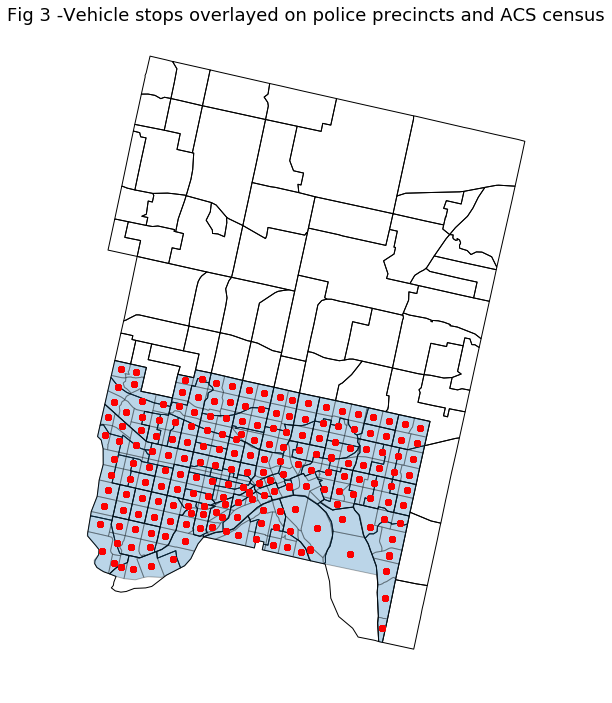

In [15]:
ax= census_acs_mn.plot(facecolor = 'None', edgecolor = 'black',figsize = (12,12))
police_precinct_mn.plot(ax=ax, alpha = 0.3,edgecolor='black')
police_records_mn.plot(ax = ax, color = 'red', alpha=0.3)
ax.set_title('Fig 3 -Vehicle stops overlayed on police precincts and ACS census', fontsize=18)
ax.set_axis_off()

This is bit unexpected chart. I was expecting vehicle stops to be spread accross geospatilly. Upon further study of data, it seems all long/lat provided are 'center' of police precinct rather than actual long/lat of incidents similar to police records in other departments data.

### Get a sense of size of vehicle stops by each precincts.

In [16]:
police_precinct_mn['center'] = police_precinct_mn['geometry'].centroid 

Geospatially join police records with police precincts and get count of records by each police precinct

In [17]:
pp_records_mn = gpd.sjoin(police_records_mn, police_precinct_mn[['gridnum','geometry']], how = 'inner', op = 'intersects')
pp_rec_count_mn = pd.DataFrame(pp_records_mn['gridnum'].value_counts())
pp_rec_count_mn.reset_index(inplace = True)
pp_rec_count_mn.columns = ['gridnum','crime_count']
police_precinct_mn = pd.merge(police_precinct_mn, pp_rec_count_mn, on = 'gridnum', how = 'left')

Use matplotlib scatter plot and use s proportional to size of vehicle stops.

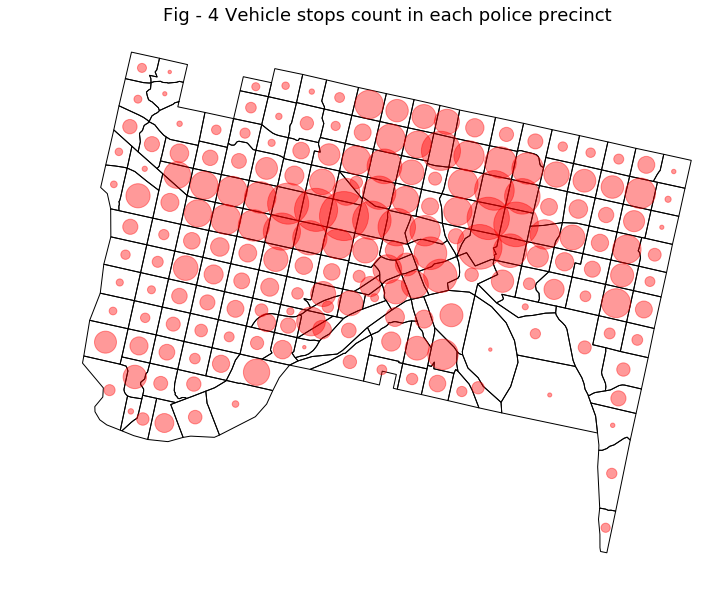

In [18]:
ax = police_precinct_mn.plot(facecolor = 'None', edgecolor = 'black',figsize = (12,12))
plt.scatter(x=police_precinct_mn['center'].apply(lambda x: Point(x).x),
           y=police_precinct_mn['center'].apply(lambda x: Point(x).y),
           s = police_precinct_mn['crime_count']/8,
           alpha=0.4,
           c='red')
ax.set_title('Fig - 4 Vehicle stops count in each police precinct', fontsize =18)
ax.set_axis_off()

### Solve the police precinct and census overlap.

Calculate area of police precinct and census track which will be used later to get % overlap.

In [19]:
# append area of each census track and police precincts to the df.
census_acs_mn['area_census'] = census_acs_mn['geometry'].area
police_precinct_mn['area_pp'] = police_precinct_mn['geometry'].area

Using gpd.overlay function to get intersection of all census tracks for each police precincts. It returns GeoDataFrame with 'geometry' of intersection. Use gpd.area to get area of intersection. Ratio of intersection area and census area will give % overlap.

In [20]:
# overlay census polygons on police precincts.
pp_census_mn = gpd.overlay(police_precinct_mn[['gridnum','geometry','area_pp']], 
                           census_acs_mn[['AFFGEOID','geometry','area_census']], 
                           how = 'intersection')
pp_census_mn['area_overlap'] = pp_census_mn['geometry'].area
pp_census_mn['percent_overlap'] = pp_census_mn['area_overlap']/pp_census_mn['area_census']*100

In [21]:
pp_census_mn.head(3)

,gridnum,area_pp,AFFGEOID,area_census,geometry,area_overlap,percent_overlap
0,280,4.012911e+05,1400000US27123042503,5.139879e+06,POLYGON ((-1193295.784589013 687770.9597793599...,3.633319e+03,0.070689
1,280,4.012911e+05,1400000US27123037403,5.728686e+06,POLYGON ((-1193303.760603478 687772.6895879221...,3.970018e+05,6.930067
2,240,1.245530e+06,1400000US27123037403,5.728686e+06,POLYGON ((-1193329.009426213 688994.3821980262...,1.245530e+06,21.741975


Take a pause!! Did everything we calculate as intended ?? Let's cross check...  
Take an example gridnum 280 has overlap with 2 census tracks. one has 6.9% overlap and other has 0.07%. Let plot it.

In [22]:
pp_census_mn[pp_census_mn['gridnum'] == '280']

,gridnum,area_pp,AFFGEOID,area_census,geometry,area_overlap,percent_overlap
0,280,401291.051881,1400000US27123042503,5.139879e+06,POLYGON ((-1193295.784589013 687770.9597793599...,3633.318696,0.070689
1,280,401291.051881,1400000US27123037403,5.728686e+06,POLYGON ((-1193303.760603478 687772.6895879221...,397001.785769,6.930067


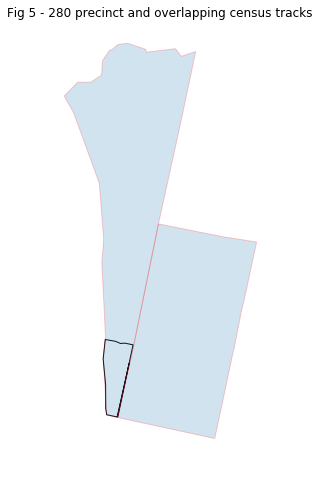

In [23]:
ax = pp_census_mn[pp_census_mn['gridnum'] == '280'].plot(figsize=(8,8),facecolor = 'None', edgecolor = 'black')
census_acs_mn[census_acs_mn['AFFGEOID'] == '1400000US27123042503'].plot(ax=ax, edgecolor='red',alpha=0.2)
census_acs_mn[census_acs_mn['AFFGEOID'] == '1400000US27123037403'].plot(ax=ax, edgecolor='red',alpha=0.2)
ax.set_title('Fig 5 - 280 precinct and overlapping census tracks')
ax.set_axis_off()

It looks correct. 0.07% overlap is actually on boundary. Due to point abberations, this tiny overlap is present which won't materially impact the analysis.  

Next check is on entire dataset, calculate overlap areas of each census track by police presinct. sum of these should equal the precinct area :). 

In [24]:
test = pd.DataFrame(pp_census_mn.groupby(by = ['gridnum'])['area_overlap'].sum())
test.reset_index(drop=False,inplace=True)
test1 = pd.merge(test,police_precinct_mn,on='gridnum')
test1['diff'] = (test1.area_pp-test1.area_overlap)/test1.area_pp*100
test1['diff'].max(),test1['diff'].min()

(1.6342299952198305, -1.7392191620711e-11)

I expect small % differnece due to same Point abberashions. These min and max are small perticularly the min. Max difference is 1.63% which is on higher side. Let's check it out for any issues.

In [25]:
test1[test1['diff'] == test1['diff'].max()]

,gridnum,area_overlap,dist,geometry,center,crime_count,area_pp,diff
112,242,1.468435e+06,Western District,"POLYGON ((-1206858.63154686 692387.6418522503,...",POINT (-1207268.336539365 692338.102669746),978.0,1.492832e+06,1.63423


In [26]:
pp_census_mn[pp_census_mn['gridnum'] == '242']

,gridnum,area_pp,AFFGEOID,area_census,geometry,area_overlap,percent_overlap
23,242,1.492832e+06,1400000US27123037601,3.197579e+06,POLYGON ((-1206967.221354426 691212.6249556675...,1.468435e+06,45.923345


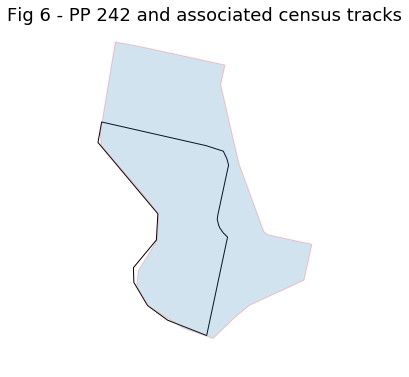

In [27]:
ax = police_precinct_mn[police_precinct_mn['gridnum'] == '242'].plot(facecolor = 'None',edgecolor = 'black',figsize=(6,6))
census_acs_mn[census_acs_mn['AFFGEOID'] == '1400000US27123037601'].plot(ax=ax, edgecolor='red',alpha=0.2)
ax.set_title('Fig 6 - PP 242 and associated census tracks', fontsize=18)
ax.set_axis_off()

There is small precinct area outside census area which explains the difference. So it is all good.  

**Coming soon!!!**  

pp_census_mn has pp grid numbers and % overlap for each associated census tracks.  

Plan next is to normalise ACS data and attribute to PP.